# Testing neuromodes vs eigenstrapping

This notebook compares the new `neuromodes.nulls.generate_surface_nulls()` implementation against the original `eigenstrapping.SurfaceEigenstrapping` class to verify correctness.

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import nibabel as nib

# Import both implementations
from brainspace.null_models.variogram import SampledSurrogateMaps
from eigenstrapping import SurfaceEigenstrapping, datasets
from neuromaps.datasets import fetch_annotation, fetch_fsaverage

from neuromodes import EigenSolver
from neuromodes.nulls import generate_nulls
from neuromodes.io import fetch_surf, fetch_map, read_surf

from nsbutils.plotting import plot_surf
from nsbutils.utils import unmask

In [17]:
# Load data. Use eigenstrapping data (fsaverage 10k) since they have already computed distmat (for variogram)

mesh_file, _, _, _, _, _, _, _ = datasets.load_surface_examples(with_surface=True)
mesh = read_surf(mesh_file)
map = nib.load(fetch_annotation(source="abagen", desc="genepc1", hemi="L")).darrays[0].data
medmask = ~np.isnan(map)
map = map[medmask]

print(mesh.vertices.shape)
print(medmask.shape)
print(map.shape)
print(np.sum(np.isnan(map)))

(10242, 3)
(10242,)
(9204,)
0


In [18]:
n_modes = 100
n_nulls = 500
seed = 365
n_jobs = 1
resample = True
normalize = True
randomize = False

In [19]:
solver = EigenSolver(mesh, mask=medmask).solve(n_modes, fix_mode1=True)
evals = solver.evals
emodes = solver.emodes

## Generate nulls using both methods


In [20]:
# Generate nulls with neuromodes
print("Generating nulls with neuromodes...")
np.random.seed(seed)  # match eigenstrapping
t1 = time.time()
nulls_neuromodes = generate_nulls(
    data=map,
    emodes=emodes[:, 1:], 
    evals=evals[1:],
    n_nulls=n_nulls,
    mask=None,  
    method='project',
    mass=solver.mass,
    resample=resample,
    randomize=randomize,
    residual=None,
    normalize=normalize,
    n_jobs=n_jobs,
    seed=seed
)
t2 = time.time()
print(f"{t2 - t1:.2f} seconds for {n_nulls} nulls.")

print(f"neuromodes nulls shape: {nulls_neuromodes.shape}")
print(f"neuromodes nulls range: [{nulls_neuromodes.min():.3f}, {nulls_neuromodes.max():.3f}]")

Generating nulls with neuromodes...
3.03 seconds for 500 nulls.
neuromodes nulls shape: (9204, 500)
neuromodes nulls range: [-2.350, 2.853]


In [21]:
# Generate nulls with eigenstrapping
print("Generating nulls with eigenstrapping...")
np.random.seed(seed)  # Set global seed for consistency
t1 = time.time()
eigen_obj = SurfaceEigenstrapping(
    data=map,
    emodes=emodes[:, 1:],
    evals=evals[1:],  
    num_modes=None,
    resample=resample,
    normalize=normalize,
    randomize=randomize,
    seed=seed,
    n_jobs=n_jobs,
    medial=None,
    add_res=False,
    permute=False 
)
nulls_eigenstrapping = eigen_obj(n=n_nulls).T
t2 = time.time()
print(f"{t2 - t1:.2f} seconds for {n_nulls} nulls.")

print(f"eigenstrapping nulls shape: {nulls_eigenstrapping.shape}")
print(f"eigenstrapping nulls range: [{nulls_eigenstrapping.min():.3f}, {nulls_eigenstrapping.max():.3f}]")

Generating nulls with eigenstrapping...
No surface given, expecting precomputed eigenvalues and eigenmodes
IMPORTANT: EIGENMODES MUST BE TRUNCATED AT FIRST NON-ZERO MODE FOR THIS FUNCTION TO WORK
3.61 seconds for 500 nulls.
eigenstrapping nulls shape: (9204, 500)
eigenstrapping nulls range: [-2.350, 2.853]


### Evaluate similarity

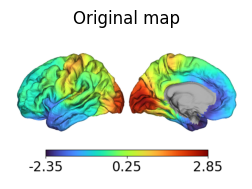

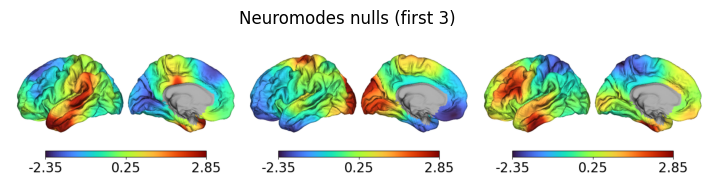

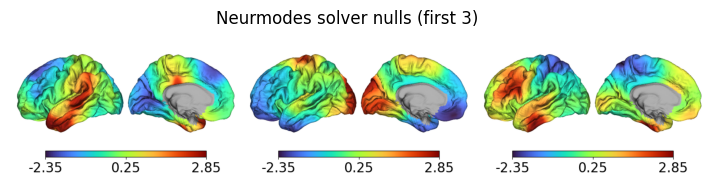

In [22]:
fig1 = plot_surf(
    mesh=mesh_file,
    data=unmask(map, medmask),
    cmap='turbo',
    cbar=True
)
plt.title("Original map")

plot_surf(
    mesh=mesh_file,
    data=unmask(nulls_neuromodes[:, :3], medmask),
    cmap='turbo',
    cbar=True
)
plt.suptitle("Neuromodes nulls (first 3)")

plot_surf(
    mesh=mesh_file,
    data=unmask(nulls_eigenstrapping[:, :3], medmask),
    cmap='turbo',
    cbar=True
)
plt.suptitle("Neurmodes solver nulls (first 3)")

plt.show()

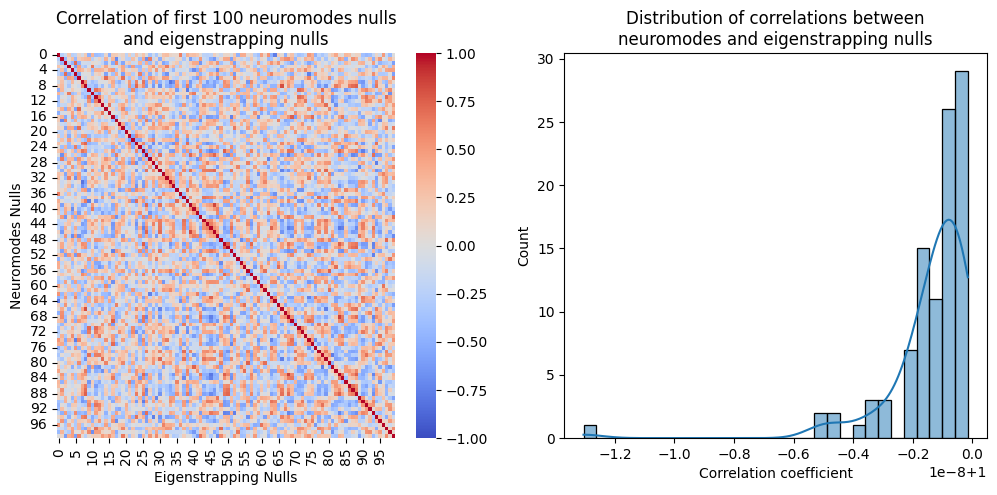

In [23]:
import seaborn as sns

null_corrs = np.corrcoef(nulls_neuromodes[:, :100].T, nulls_eigenstrapping[:, :100].T)[:100, 100:]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(null_corrs, vmin=-1, vmax=1, cmap='coolwarm', ax=axs[0])
axs[0].set_title("Correlation of first 100 neuromodes nulls\nand eigenstrapping nulls")
axs[0].set_xlabel("Eigenstrapping Nulls")
axs[0].set_ylabel("Neuromodes Nulls")

sns.histplot(np.diagonal(null_corrs), bins=30, kde=True, ax=axs[1])
axs[1].set_title("Distribution of correlations between\nneuromodes and eigenstrapping nulls")
axs[1].set_xlabel("Correlation coefficient")
plt.show()

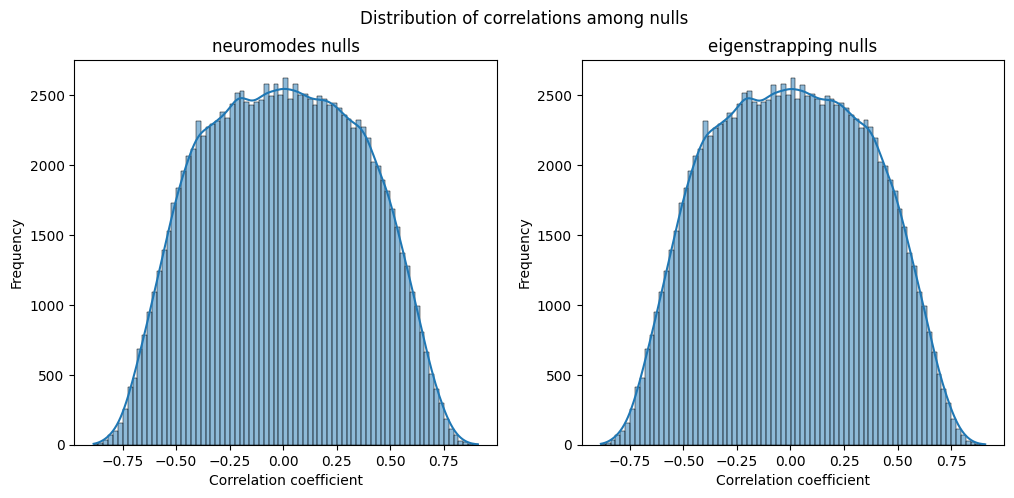

In [24]:
null_corrs_neuromaps = np.corrcoef(nulls_neuromodes.T)
null_corrs_eigenstrapping = np.corrcoef(nulls_eigenstrapping.T)
triu_indices = np.triu_indices_from(null_corrs_neuromaps, k=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Distribution of correlations among nulls")

sns.histplot(null_corrs_neuromaps[triu_indices], kde=True, ax=axs[0])
axs[0].set_title("neuromodes nulls")
axs[0].set_xlabel("Correlation coefficient")
axs[0].set_ylabel("Frequency")

sns.histplot(null_corrs_eigenstrapping[triu_indices], kde=True, ax=axs[1])
axs[1].set_title("eigenstrapping nulls")
axs[1].set_xlabel("Correlation coefficient")
axs[1].set_ylabel("Frequency")

plt.show()

In [25]:
distmat, index = datasets.load_distmat('fsaverage', hemi='lh', sort=True)

In [26]:
# Setup variogram generator (using eigenstrapping's default params from fit.py)
print("Setting up variogram generator...")
var_params = {'ns': 500, 'pv': 70, 'nh': 25, 'knn': 1000}
generator = SampledSurrogateMaps(**var_params)
generator.fit(distmat, index)

# Determine number of variogram samples (eigenstrapping uses min(50, nsurrs))
nsurrs_var = min(50, n_nulls)
print(f"Computing variograms using {nsurrs_var} samples...")

# Compute empirical and surrogate variograms (following eigenstrapping's fit.py exactly)
surr_var_nm = np.empty((nsurrs_var, generator.nh))
surr_var_es = np.empty((nsurrs_var, generator.nh))
emp_var_samples = np.empty((nsurrs_var, generator.nh))
u0_samples = np.empty((nsurrs_var, generator.nh))

# Need to unmask the nulls for variogram computation
nulls_nm_full = unmask(nulls_neuromodes[:, :nsurrs_var], medmask).T
nulls_es_full = unmask(nulls_eigenstrapping[:, :nsurrs_var], medmask).T
map_full = unmask(map, medmask)

for i in range(nsurrs_var):
    # Check map format
    xi = generator._check_map(map_full)
    
    # Randomly sample subset of brain areas
    idx = generator.sample(xi.size)
    
    # Compute empirical variogram
    v = generator.compute_variogram(xi, idx)
    u = generator._dist[idx, :]
    umax = np.percentile(u, generator.pv)
    uidx = np.where(u < umax)
    emp_var_i, u0i = generator.smooth_variogram(u=u[uidx], v=v[uidx], return_h=True)
    emp_var_samples[i], u0_samples[i] = emp_var_i, u0i
    
    # Compute neuromodes surrogate variogram
    surri_nm = generator._check_map(nulls_nm_full[i])
    v_null_nm = generator.compute_variogram(surri_nm, idx)
    surr_var_nm[i] = generator.smooth_variogram(u=u[uidx], v=v_null_nm[uidx], return_h=False)
    
    # Compute eigenstrapping surrogate variogram
    surri_es = generator._check_map(nulls_es_full[i])
    v_null_es = generator.compute_variogram(surri_es, idx)
    surr_var_es[i] = generator.smooth_variogram(u=u[uidx], v=v_null_es[uidx], return_h=False)

# Average across samples
u0 = u0_samples.mean(axis=0)
emp_var = emp_var_samples.mean(axis=0)

Setting up variogram generator...
Computing variograms using 50 samples...


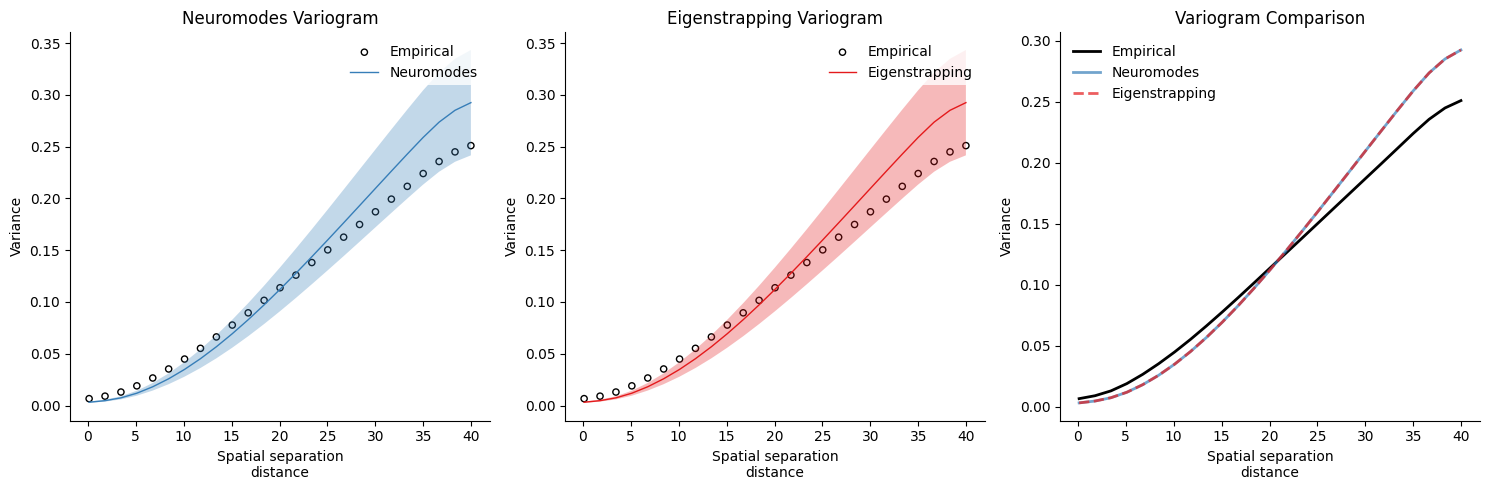

In [27]:
# Create three-panel plot following eigenstrapping's fit.surface_fit style
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# neuromodes variogram
ax = axes[0]
ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',
           marker='o', lw=1, label='Empirical')
mu_nm = surr_var_nm.mean(axis=0)
sigma_nm = surr_var_nm.std(axis=0)
ax.fill_between(u0, mu_nm-sigma_nm, mu_nm+sigma_nm, facecolor='#377eb8',
                edgecolor='none', alpha=0.3)
ax.plot(u0, mu_nm, color='#377eb8', label='Neuromodes', lw=1)
leg = ax.legend(loc=0)
leg.get_frame().set_linewidth(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Spatial separation\ndistance")
ax.set_ylabel("Variance")
ax.set_title("Neuromodes Variogram")

# Eigenstrapping variogram
ax = axes[1]
ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',
           marker='o', lw=1, label='Empirical')
mu_es = surr_var_es.mean(axis=0)
sigma_es = surr_var_es.std(axis=0)
ax.fill_between(u0, mu_es-sigma_es, mu_es+sigma_es, facecolor='#e41a1c',
                edgecolor='none', alpha=0.3)
ax.plot(u0, mu_es, color='#e41a1c', label='Eigenstrapping', lw=1)
leg = ax.legend(loc=0)
leg.get_frame().set_linewidth(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Spatial separation\ndistance")
ax.set_ylabel("Variance")
ax.set_title("Eigenstrapping Variogram")

# comparison of variogram means
ax = axes[2]
ax.plot(u0, emp_var, 'k-', lw=2, label='Empirical')
ax.plot(u0, mu_nm, color='#377eb8', lw=2, label='Neuromodes', alpha=0.7)
ax.plot(u0, mu_es, color='#e41a1c', lw=2, label='Eigenstrapping', alpha=0.7, linestyle='--')
leg = ax.legend(loc=0)
leg.get_frame().set_linewidth(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Spatial separation\ndistance")
ax.set_ylabel("Variance")
ax.set_title("Variogram Comparison")

plt.tight_layout()
plt.show()

In [28]:
# distmat_masked = distmat.copy()
# distmat_masked[~medmask, :] = np.nan
# distmat_masked[:, ~medmask] = np.nan

# print(np.sum(np.isnan(distmat_masked[0, :])))

In [29]:
# def calc_morans_i(dist, data, normalize_weights=False):
#     """
#     Calculate Moran's I for spatial autocorrelation.
    
#     Parameters
#     ----------
#     dist : (N, N) array_like
#         Distance matrix. NaN values indicate medial wall.
#     data : (N,) or (N, M) array_like
#         Brain map(s) to calculate Moran's I for. If 2D, computes for each column.
#     normalize_weights : bool, optional
#         Whether to normalize weight matrix rows. Default: False
    
#     Returns
#     -------
#     moran_i : float or (M,) array
#         Moran's I value(s)
#     """
#     # Handle 1D vs 2D input
#     if data.ndim == 1:
#         data = data[:, np.newaxis]
#         squeeze_output = True
#     else:
#         squeeze_output = False
    
#     # Convert distance to weights by inverting (closer = higher weight)
#     with np.errstate(divide='ignore', invalid='ignore'):
#         weights = 1.0 / dist
    
#     # Set diagonal to zero (no self-weight)
#     np.fill_diagonal(weights, 0)
    
#     # Handle NaNs: set them to zero weight
#     weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0)
    
#     # Normalize weights if requested
#     if normalize_weights:
#         row_sums = weights.sum(axis=1, keepdims=True)
#         row_sums[row_sums == 0] = 1  # Avoid division by zero
#         weights = weights / row_sums
    
#     # Compute Moran's I for each column
#     n = weights.shape[0]
#     W = weights.sum()  # Sum of all weights
    
#     morans = []
#     for i in range(data.shape[1]):
#         y = data[:, i]
        
#         # Handle NaNs in data
#         valid = ~np.isnan(y)
#         if not valid.all():
#             y_clean = y[valid]
#             w_clean = weights[np.ix_(valid, valid)]
#             n_clean = valid.sum()
#             W_clean = w_clean.sum()
#         else:
#             y_clean = y
#             w_clean = weights
#             n_clean = n
#             W_clean = W
        
#         # Calculate Moran's I
#         z = y_clean - y_clean.mean()
#         zl = w_clean @ z
#         numerator = (z * zl).sum()
#         denominator = (z * z).sum()
        
#         if W_clean > 0 and denominator > 0:
#             moran_i = (n_clean / W_clean) * (numerator / denominator)
#         else:
#             moran_i = np.nan
        
#         morans.append(moran_i)
    
#     result = np.array(morans)
#     return result[0] if squeeze_output else result


# # Test with your data
# print("Computing Moran's I...")
# moran_original = calc_morans_i(distmat_masked, unmask(map.reshape(-1, 1), medmask))
# print(f"Original map Moran's I: {moran_original[0]:.6f}")

# # Compute for all nulls
# print("Computing Moran's I for neuromodes nulls...")
# moran_nm = calc_morans_i(distmat_masked, unmask(nulls_neuromodes, medmask))

# print("Computing Moran's I for eigenstrapping nulls...")
# moran_es = calc_morans_i(distmat_masked, unmask(nulls_eigenstrapping, medmask))

# print(f"\nNeuromodes mean: {np.mean(moran_nm):.6f} ± {np.std(moran_nm):.6f}")
# print(f"Eigenstrapping mean: {np.mean(moran_es):.6f} ± {np.std(moran_es):.6f}")

In [30]:
# # Plot distributions
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# # Histogram comparison
# axes[0].hist(moran_nm, bins=30, alpha=0.6, label='Neuromodes', color='blue', density=True)
# axes[0].hist(moran_es, bins=30, alpha=0.6, label='Eigenstrapping', color='red', density=True)
# axes[0].axvline(moran_original, color='black', linestyle='--', linewidth=2, label='Original')
# axes[0].set_xlabel("Moran's I")
# axes[0].set_ylabel('Density')
# axes[0].set_title("Distribution of Moran's I")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # Scatter plot
# axes[1].scatter(moran_nm, moran_es, alpha=0.5, s=20)
# axes[1].plot([min(moran_nm), max(moran_nm)], [min(moran_nm), max(moran_nm)], 'k--', label='Identity')
# axes[1].set_xlabel("Neuromodes Moran's I")
# axes[1].set_ylabel("Eigenstrapping Moran's I")
# axes[1].set_title("Moran's I Comparison")
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# # Boxplot
# axes[2].boxplot([moran_nm, moran_es], labels=['Neuromodes', 'Eigenstrapping'])
# axes[2].axhline(moran_original, color='black', linestyle='--', linewidth=2, label='Original')
# axes[2].set_ylabel("Moran's I")
# axes[2].set_title("Moran's I Distribution")
# axes[2].legend()
# axes[2].grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
# plt.show()

# # Print statistics
# print(f"\nMoran's I Statistics:")
# print(f"  Original map: {moran_original[0]:.6f}")
# print(f"  Neuromodes nulls: {np.mean(moran_nm):.6f} ± {np.std(moran_nm):.6f}")
# print(f"  Eigenstrapping nulls: {np.mean(moran_es):.6f} ± {np.std(moran_es):.6f}")
# print(f"  Correlation between implementations: {np.corrcoef(moran_nm, moran_es)[0,1]:.10f}")